In [1]:
import glob
import os
from tqdm import tqdm
import ast
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from azure.storage.blob import BlobServiceClient

In [2]:
# Storage container config
storage_account_key = "856t0JodjM+g9WGmLKsKtwqFbAgtTONU7MyqgG2WVtzeI9e1bTQsA/yk49zvVxfH3NkG92DG9DVw+AStiIW+/Q=="
storage_account_name = "pqdatawarehouse"
connection_string = "DefaultEndpointsProtocol=https;AccountName=pqdatawarehouse;AccountKey=856t0JodjM+g9WGmLKsKtwqFbAgtTONU7MyqgG2WVtzeI9e1bTQsA/yk49zvVxfH3NkG92DG9DVw+AStiIW+/Q==;EndpointSuffix=core.windows.net"
container_name = "ant-datalake"

blob_service_client = BlobServiceClient.from_connection_string(connection_string)

In [3]:

def get_blobs(container_name, prefix):
    """List blobs from a storage container.

    Args:
        container_name (string): name of the container
        prefix (string): _description_

    Returns:
        list: list of all blobs in the container.
    """
    container_client = blob_service_client.get_container_client(
        container=container_name)
    blob_list = container_client.list_blobs(name_starts_with=prefix)

    all_blobs = [blob.name for blob in blob_list]

    return all_blobs

def download_blob(blob, destination, container_name=container_name):
    """Download blobs from an storage container to a local directory.

    Args:
        blob (_type_): _description_
        container_name (_type_, optional): _description_. Defaults to container_name.
        destination (str, optional): _description_. Defaults to 'sample_plots'.
    """

    blob_client = blob_service_client.get_blob_client(
        container=container_name, blob=blob)

    file_name = os.path.basename(blob)

    with open(file=os.path.join(destination, file_name), mode="wb") as sample_blob:
        download_stream = blob_client.download_blob()
        sample_blob.write(download_stream.readall())


def extract_datetime(name):
    """Get datetime from the file name."""
    date_str = name.replace("-PLOT.parquet", "").split(")")[-1]
    return str(datetime.strptime(date_str, '%m %d %Y %H %M'))


def plot(cols, df):
    """Displays a scatter plot of a given column/s"""
    _, ax = plt.subplots(figsize=(8, 8))
    df = df.to_frame().T

    for col in cols:
        series = df[col].apply(ast.literal_eval).explode()
        x_coord = series.apply(lambda x: x[0]).values
        y_coord = series.apply(lambda x: x[1]).values

        if 'Fitted' in col:
            ax.plot(x_coord, y_coord, label=col)
        else:
            ax.scatter(x_coord, y_coord, s=0.5, label=col)
    plt.legend()
    plt.show()


#### Note:

The general data lake structure is as follows:
* <b>Region</b> (Baguio, East Aurora, etc.)
    * <b> Business Unit </b> (CBU, HBU, GBU, etc.)
        * <b> Product </b> (D026-001D, -026-284B, etc.)
            * <b> HNULL </b>
                * <b> Data Type </b>(PLOT, DFQ or RES)
                    * <b>Year</b>
                        * <b>Month</b>
                            * <b>Day</b>
            * <b> MAIN </b>
                * <b> Category </b>(Pre-ATP, Final-ATP, etc.)
                    * <b> Data Type </b> (PLOT, DFQ or RES)
                        * <b> Year</b>
                            * <b> Month</b>
                                * <b> Day</b>


In [4]:
# Sample code to query all D026-001D HNULL plot data 
plot_files = get_blobs(container_name = container_name, prefix = 'Baguio/CBU/D026-001D/HNULL/PLOTS/' )

In [9]:
# get blobs return directory. retain only parquet files
plot_files_filtered = [file for file in plot_files if '.parquet' in file]

In [10]:
print(f"No. of plot data for D026-001D: {len(plot_files_filtered)}")

No. of plot data for D026-001D: 16716


In [11]:
download_path = "../sample_plots"

if not os.path.exists(download_path):
    os.makedirs(download_path)

# Method very slow. Will modify / use threadpool to allow parallel downloads
for file in tqdm(plot_files_filtered[:15]):
    download_blob(blob=file, destination=download_path)

100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


In [13]:
downloaded_plots = glob.glob("../sample_plots/*.parquet")
downloaded_plots

['../sample_plots\\D026-001D(B90839)04 29 2020 20 37-PLOT.parquet',
 '../sample_plots\\D026-001D(B90839)04 29 2020 20 42-PLOT.parquet',
 '../sample_plots\\D026-001D(B90839)04 29 2020 21 16-PLOT.parquet',
 '../sample_plots\\D026-001D(B90863)04 29 2020 22 00-PLOT.parquet',
 '../sample_plots\\D026-001D(B92839)04 29 2020 20 22-PLOT.parquet',
 '../sample_plots\\D026-001D(B92839)04 29 2020 21 31-PLOT.parquet',
 '../sample_plots\\D026-001D(B92846)04 29 2020 20 06-PLOT.parquet',
 '../sample_plots\\D026-001D(B92846)04 29 2020 20 12-PLOT.parquet',
 '../sample_plots\\D026-001D(B92846)04 29 2020 22 15-PLOT.parquet',
 '../sample_plots\\D026-001D(B92846)04 29 2020 22 31-PLOT.parquet',
 '../sample_plots\\D026-001D(B92846)04 30 2020 16 01-PLOT.parquet',
 '../sample_plots\\D026-001D(B92846)04 30 2020 16 25-PLOT.parquet',
 '../sample_plots\\D026-001D(B92846)04 30 2020 17 38-PLOT.parquet',
 '../sample_plots\\D026-001D(B92846)04 30 2020 18 02-PLOT.parquet',
 '../sample_plots\\D026-001D(B92848)04 29 2020 2

In [14]:
sn = "B92846"
selected_files = [i for i in downloaded_plots if sn in i]
dates = [extract_datetime(file) for file in selected_files]
df = pd.concat(map(pd.read_parquet, selected_files)).reset_index(drop=True)
df['Datetime'] = dates

df.sort_values("Datetime")

,Temperature,LandD_Raw,LandC_Raw,LandB_Raw,LandA_Raw,LandD_Fitted,LandC_Fitted,LandB_Fitted,LandA_Fitted,ExpandedFlow_Raw,InternalLeakage_Raw,PressureGain_Raw,DroopPressure_Raw,Datetime
0,34.514605,"((-0.006677788, 5.461203763), (-0.000844173, 0...","((0.002116187, 1.784365573), (0.010958954, 6.5...","((-0.001486944, 1.147108076), (-0.007736704, 7...","((0.01001593, 5.828972575), (0.008838836, 5.52...","((-0.006269891, 4.8), (1.858e-06, 0.0))","((-0.000101085, 0.0), (0.005843844, 4.8))","((-0.006043068, 4.8), (-5.8287e-05, 0.0))","((0.005861412, 4.8), (-0.000213382, 0.0))","((0.021189166, 0.011679081), (0.021150693, 0.0...","((0.007809282, 0.011084556), (0.030573757, 0.0...","((2965.487635028, 0.008471259), (2954.81641233...","((0.0, 0.0),)",2020-04-29 20:06:00
1,36.457452,"((-0.002320572, 1.840308173), (-0.008501423, 5...","((0.003665558, 2.946539474), (0.003546388, 2.8...","((-0.006327733, 4.719047905), (-0.005377761, 4...","((0.00323473, 2.662203013), (0.007795966, 6.32...","((-8.462e-06, 0.0), (-0.006061255, 4.8))","((0.006088417, 4.8), (-8.6883e-05, 0.0))","((-0.006264592, 4.8), (-6.1768e-05, 0.0))","((0.006077285, 4.8), (-0.000211194, 0.0))","((0.030797821, 0.011710022), (0.030043134, 0.0...","((0.079885693, 0.011643138), (0.005734983, 0.0...","((2947.599259942, 0.010348517), (2960.40482388...","((0.0, 0.0),)",2020-04-29 20:12:00
2,39.621661,"((-0.00788189, 5.92340779), (-0.009893662, 5.6...","((0.007266514, 6.508604402), (0.00331235, 3.01...","((-0.009948076, 6.985597832), (-0.00833978, 6....","((0.008063358, 5.955871353), (0.001062479, 1.3...","((-0.000447154, 0.0), (-0.006703487, 4.8))","((-0.000527435, 0.0), (0.005621684, 4.8))","((-0.000510232, 0.0), (-0.00670287, 4.8))","((0.005419398, 4.8), (-0.000620054, 0.0))","((2.247102079, 0.013975294), (2.151641019, 0.0...","((0.105344558, 0.011765726), (0.075999127, 0.0...","((2951.240109669, 0.008427304), (-2976.9319419...","((0.0, 0.0),)",2020-04-29 22:15:00
3,39.568392,"((-0.009238118, 5.582072094), (-0.002478979, 1...","((0.00805628, 7.292573113), (0.006338887, 5.10...","((-0.001147426, 0.788928546), (-0.011049428, 6...","((0.004439815, 3.702648094), (0.009462724, 5.6...","((-7.1035e-05, 0.0), (-0.006300901, 4.8))","((-0.000144511, 0.0), (0.005778289, 4.8))","((-0.006325491, 4.8), (-0.000119705, 0.0))","((-0.000226458, 0.0), (0.005781794, 4.8))","((-0.791865006, 0.010815214), (-1.593182476, 0...","((0.007154204, 0.010846187), (0.010476581, 0.0...","((-2955.279213014, 0.022437586), (-2956.597452...","((0.0, 0.0),)",2020-04-29 22:31:00
4,32.392316,"((-0.005084205, 3.884995742), (-0.00377947, 2....","((0.002563306, 2.053883362), (0.007151044, 6.4...","((-0.005946786, 4.705128366), (-0.004945867, 3...","((0.003354431, 2.768786074), (0.010367269, 5.5...","((1.0333e-05, 0.0), (-0.006263733, 4.8))","((0.006152408, 4.8), (-0.000156779, 0.0))","((-0.006058808, 4.8), (-5.068e-05, 0.0))","((-0.000212751, 0.0), (0.006033228, 4.8))","((0.280388529, 0.012082481), (-0.130924235, 0....","((0.007829175, 0.011138531), (0.005903726, 0.0...","((2958.005462419, 0.003957459), (-2963.9534712...","((0.0, 0.0),)",2020-04-30 16:01:00
5,35.4358,"((-0.008252992, 5.95181025), (-0.009118234, 5....","((0.00735495, 6.254274339), (0.005020876, 4.06...","((-0.00300027, 2.280000905), (-0.010137083, 6....","((0.007301214, 6.048599544), (0.006621246, 5.6...","((2.6804e-05, 0.0), (-0.006247431, 4.8))","((-5.3177e-05, 0.0), (0.005864106, 4.8))","((-0.006274297, 4.8), (-4.4601e-05, 0.0))","((-0.000205672, 0.0), (0.006070836, 4.8))","((-0.410006044, 0.011289556), (0.754988191, 0....","((0.004565445, 0.01041447), (0.005740128, 0.01...","((2951.570940082, 0.004613315), (2954.43967987...","((0.0, 0.0),)",2020-04-30 16:25:00
6,35.49466,"((-0.003634717, 2.816297092), (-0.000891996, 0...","((0.007871497, 6.510859067), (0.006504745, 6.0...","((-0.005575308, 4.170851482), (-0.007632984, 6...","((0.004019342, 3.332173743), (0.008395911, 5.3...","((-0.006262272, 4.8), (1.1271e-05, 0.0))","((0.006128304, 4.8), (-0.000130

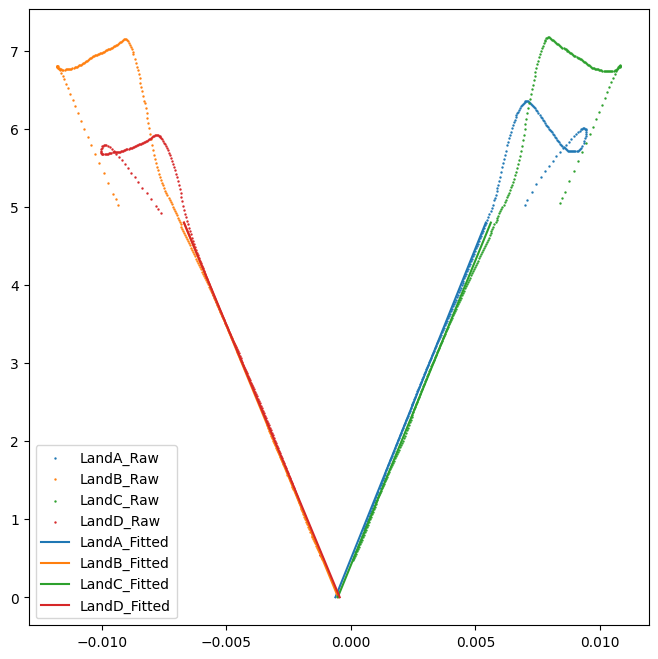

In [19]:
lands = 'ABCD'
plot([f"Land{i}_Raw" for i in lands]+[f"Land{i}_Fitted" for i in lands], df.iloc[2])

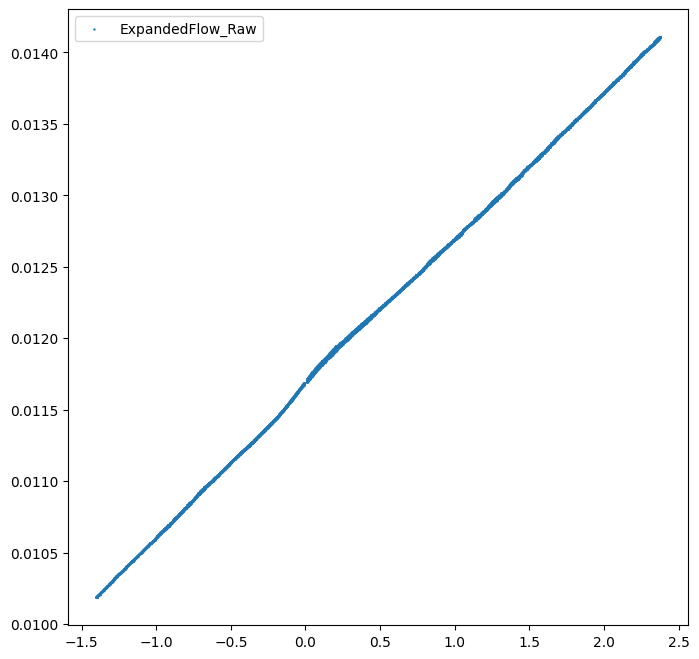

In [18]:
plot(["ExpandedFlow_Raw"], df.iloc[2])

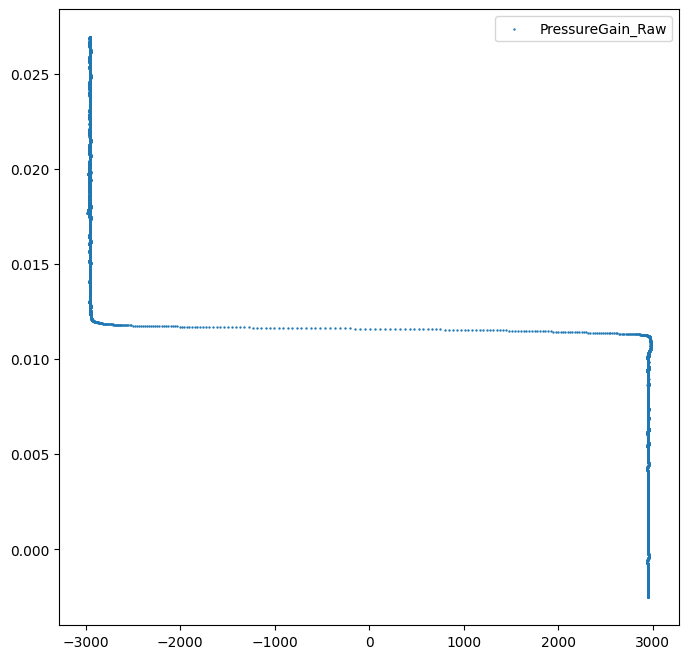

In [20]:
plot(["PressureGain_Raw"], df.iloc[2])

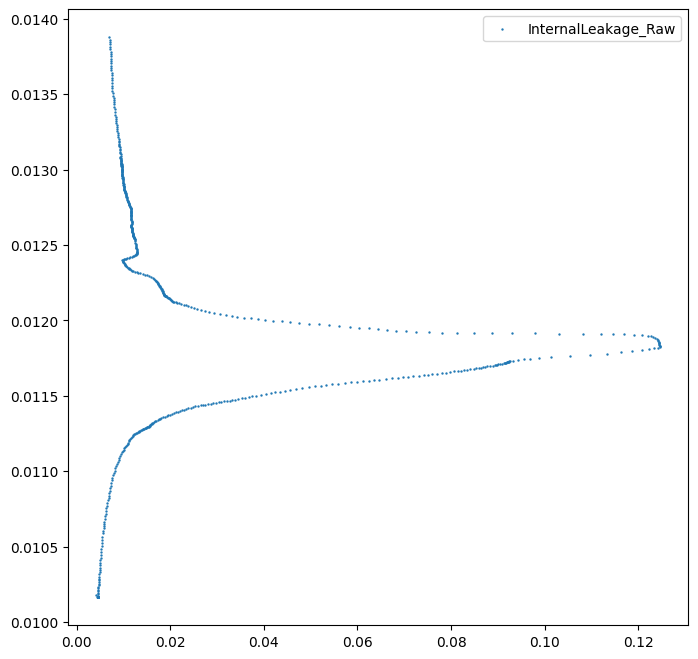

In [21]:
plot(["InternalLeakage_Raw"], df.iloc[2])